# Description
This notebook aims to compare the models performance accross different segments

# Setup

In [1]:
import pandas as pd
import plotly.express as px
import re
import numpy as np
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import joblib
import shap

import findspark
import pyspark
from pyspark.sql import SparkSession
import pyspark
from pyspark.sql import DataFrame
import pyspark.sql.functions as sql
from pyspark.sql.window import Window
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.functions import vector_to_array
from Utils import addWoeFromSavedDF, spark, output_path, input_path, pysparkGiniPerGroups

/home/neon/Documents/lending-club-analysis/lending-club-analysis/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
25/06/12 15:56:56 WARN Utils: Your hostname, pop-os-note resolves to a loopback address: 127.0.0.1; using 192.168.0.4 instead (on interface wlp2s0)
25/06/12 15:56:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
https://mmlspark.azureedge.net/maven added as a remote repository with the name: repo-1


:: loading settings :: url = jar:file:/home/neon/Documents/lending-club-analysis/lending-club-analysis/.venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/neon/.ivy2/cache
The jars for the packages stored in: /home/neon/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-42925310-2bd3-445b-906e-02c0a9e9fc05;1.0
	confs: [default]
	found com.microsoft.azure#synapseml_2.12;1.0.11 in central
	found com.microsoft.azure#synapseml-core_2.12;1.0.11 in central
	found org.apache.spark#spark-avro_2.12;3.4.1 in central
	found org.tukaani#xz;1.9 in central
	found commons-lang#commons-lang;2.6 in central
	found org.scalactic#scalactic_2.12;3.2.14 in central
	found org.scala-lang#scala-reflect;2.12.15 in central
	found io.spray#spray-json_2.12;1.3.5 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents.client5#httpclient5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5-h2;5.1.3 in central
	found org.slf4j#slf4j-api;1.7.25 in ce

# Data

In [2]:
train_data = spark.read.parquet(f"{output_path}train_df_woe.parquet")
test_data  = spark.read.parquet(f"{output_path}test_df_woe.parquet")

# Models

In [88]:
models_dict = {
    'log_reg'  : PipelineModel.load(f"{output_path}_log_reg.gz")
    # 'log_reg2' : PipelineModel.load(f"{output_path}_log_reg2.gz")
}

# Analysis

## with PRed

In [94]:
def withPrediction(df: DataFrame, model, model_name: str, id_col: str):
    pred_col = model.stages[-1].getPredictionCol()
    input_cols = model.stages[0].getInputCols()

    pred_df = df\
        .select([id_col] + input_cols)\
        .transform(model.transform)\
        .withColumnRenamed(pred_col, f"{model_name}_pred")
    
    result = df\
            .join(pred_df.select(id_col, f"{model_name}_pred"), [id_col], "left")
    return result

def withMultiplePrediction(df: DataFrame, models_dict: dict, id_col: str = 'id'):
    
    result = df
    for model_name, model in models_dict.items():
        result = result\
                .transform(withPrediction, model, model_name, id_col)
    return result

test_data_with_pred = test_data\
.transform(withMultiplePrediction, models_dict, 'id')\
.cache()

## Actuals vs Predictions

In [ ]:
def withQuantileCuts(df: DataFrame, col_to_bin: str, n_bins: int):
    from pyspark.ml.feature import QuantileDiscretizer
    result = df.drop(f'{col_to_bin}_bands')
    if df.schema[col_to_bin].dataType.simpleString() in ["double", "int"]:
        quantDisc = QuantileDiscretizer(inputCol=col_to_bin, 
                                        outputCol=f'{col_to_bin}_bands', 
                                        numBuckets=n_bins, 
                                        handleInvalid="keep")
        
        w1 = Window.partitionBy(f'{col_to_bin}_bands').rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
        
        result = quantDisc\
                    .fit(result)\
                    .transform(result)\
                    .withColumn(f'{col_to_bin}_bands', 
                                concat(char(col(f'{col_to_bin}_bands') + 97),
                                       lit(". "),
                                       min(col(col_to_bin)).over(w1),
                                       lit("-"),
                                       max(col(col_to_bin)).over(w1)))
    else:
        result = df.withColumn(f"{col_to_bin}_bands", F.col(col_to_bin))
    return result

def withMultipleQuantiles(df: DataFrame, group_cols: dict):
    
    result = df
    for col_to_bin, n_bins in group_cols.items():
        result = result\
                .transform(withQuantileCuts, col_to_bin, n_bins)
    return result
    
def withGroupedActVsPred(df: DataFrame, group_cols: dict, models_dict: dict):
    act_agg = [F.avg("default_flag").alias("actuals")]
    pred_agg = [F.avg(f"{pred_name}_pred").alias(f"{pred_name}_pred") for pred_name in models_dict.keys()]
    all_agg = act_agg + pred_agg
        
    result = df\
        .groupBy([f"{group_col}_bands" for group_col in group_cols.keys()])\
        .agg(*all_agg)\
        .orderBy([f"{group_col}_bands" for group_col in group_cols.keys()])
    
    return result



In [112]:
group_cols = {"fico_range_low" : 10}

data_chart = test_data_with_pred\
.transform(withMultipleQuantiles, group_cols)\
.transform(withGroupedActVsPred, group_cols, models_dict)\
.toPandas()\
.melt(id_vars=[f"{i}_bands" for i in group_cols.keys()])

fig = px.line(
    data_chart,
    x=[f"{i}_bands" for i in group_cols.keys()][0],
    y="value",
    color='variable',
    width=700,
    template='simple_white'
)
fig.update_traces(patch={'line':{'dash':'dash', 'width':3}})
fig.update_traces(patch={'line':{'dash':'solid', 'color':'black', 'width':2}}, selector={'name':'actuals'})
fig

25/06/12 15:03:48 WARN MemoryStore: Not enough space to cache rdd_780_3 in memory! (computed 57.4 MiB so far)
25/06/12 15:03:50 WARN MemoryStore: Not enough space to cache rdd_780_3 in memory! (computed 57.4 MiB so far)


In [126]:
group_cols = {"log_reg_pred" : 10}

data_chart = test_data_with_pred\
.transform(withMultipleQuantiles, group_cols)\
.transform(withGroupedActVsPred, group_cols, models_dict)\
.toPandas()\
.melt(id_vars=[f"{i}_bands" for i in group_cols.keys()])

fig = px.line(
    data_chart,
    x=[f"{i}_bands" for i in group_cols.keys()][0],
    y="value",
    color='variable',
    width=700,
    template='simple_white'
)
fig.update_traces(patch={'line':{'dash':'dash', 'width':3}})
fig.update_traces(patch={'line':{'dash':'solid', 'color':'black', 'width':2}}, selector={'name':'actuals'})
fig

25/06/12 15:23:48 WARN MemoryStore: Not enough space to cache rdd_780_1 in memory! (computed 57.6 MiB so far)
25/06/12 15:23:51 WARN MemoryStore: Not enough space to cache rdd_780_1 in memory! (computed 57.6 MiB so far)


## Gini

In [ ]:
test_data_with_pred\
.withColumn("group", lit(1))\
.withColumn("rand", F.rand(seed=42))\
.melt(ids=["default_flag"], 
      values=[f"{i}_pred" for i in models_dict.keys()] + ['rand'],
      variableColumnName="model",
      valueColumnName="pred")\
.transform(pysparkGiniPerGroups, ['model'], "pred", "default_flag")\
.show()


25/06/12 15:32:39 WARN MemoryStore: Not enough space to cache rdd_780_1 in memory! (computed 57.6 MiB so far)
/tmp/ipykernel_13344/2817747968.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


+------------+-------------------+--------------------+
|       model|                auc|                gini|
+------------+-------------------+--------------------+
|log_reg_pred| 0.7097012357032197|  0.4194024714064395|
|        rand|0.49905498891708105|-0.00189002216583...|
+------------+-------------------+--------------------+



/tmp/ipykernel_13344/2817747968.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


## Shap and PDP

In [ ]:
class applyShapToPysparkModel:
    def __init__(self,
                 model: PipelineModel,
                 n_samples: int,
                 random_state: int = 42):
        self.model = model
        self.n_samples = n_samples
        self.random_state = random_state
        self.features = self.model.stages[0].getInputCols()
        self.predictionCol = self.model.stages[-1].getPredictionCol()
        
    
    def explain(self, data: DataFrame, log_odds: bool = False):
        import lightgbm as lgbm
        import time
        start_time = time.time()
        print(f"{time.time()} extracting pyspark data to pandas df")
        self.train_pd = data\
                        .select(self.features)\
                        .transform(self.model.transform)\
                        .withColumn("log_odds", F.log(F.col(self.predictionCol) / (lit(1.0) - F.col(self.predictionCol))))\
                        .orderBy(rand(seed=self.random_state))\
                        .limit(self.n_samples)\
                        .toPandas()
        
        print(f"{time.time()} training LGBM")
        self.explainer_tree = lgbm.LGBMRegressor(verbosity=-1, random_state=self.random_state)
        xtrain = self.train_pd[self.features]
        if log_odds:
            ytrain = self.train_pd["log_odds"]
        else:
            ytrain = self.train_pd[self.predictionCol]
        self.explainer_tree.fit(xtrain, ytrain)
        self.explainer = shap.TreeExplainer(self.explainer_tree)
        
        print(f"{time.time()} explaining model")
        self.shap_values = self.explainer(xtrain)

        print(f"finshed explain {time.time() - start_time}")
    
    def calculate_shap_values(self):
        self.shap_values = self.explainer(self.data)
    
    def beeswarm_plot(self, max_display=20, log_scale=False):
        try:
            shap.plots.beeswarm(self.shap_values, max_display = max_display, log_scale = log_scale)
        except:
            shap.plots.beeswarm(self.shap_values[:,:,1], max_display = max_display, log_scale = log_scale)
    
    def partial_dependence_plot(self, col_names: list):
        import matplotlib.pyplot as plt
        from sklearn.inspection import PartialDependenceDisplay

        fig, ax = plt.subplots(figsize=(14, 2.5))
        if len(col_names) <= 1:
            col_list = col_names
        else:
            col_list = [col_names[0], col_names[1], (col_names[0], col_names[1])]
        PartialDependenceDisplay.from_estimator(self.explainer_tree,
                                                self.train_pd[self.features],
                                                col_list,
                                                ax=ax)
        

In [ ]:
shap_explainer = applyShapToPysparkModel(models_dict['log_reg'], 5000)
shap_explainer.explain(train_data)

1749732587.9382896 extracting pyspark data to pandas df


1749732593.715757 training LGBM
1749732595.5667458 explaining model
finshed explain 14.500091791152954


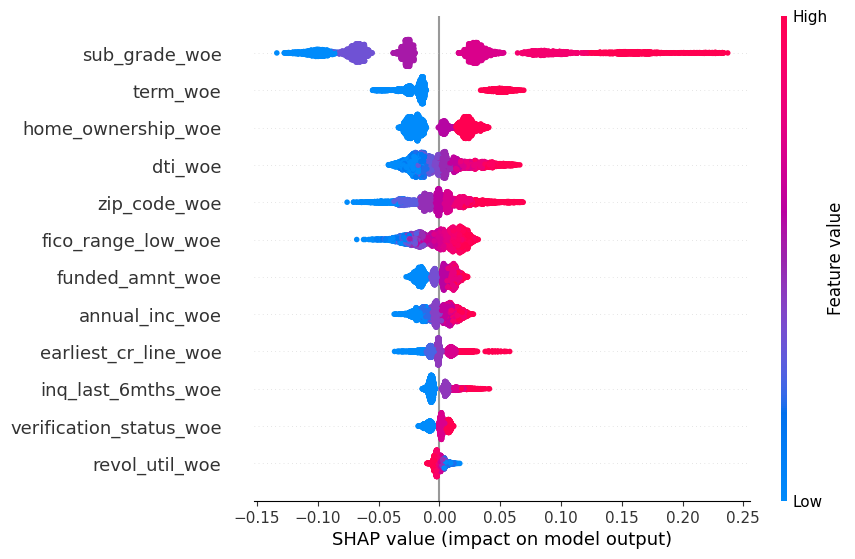

In [61]:
shap_explainer.beeswarm_plot()

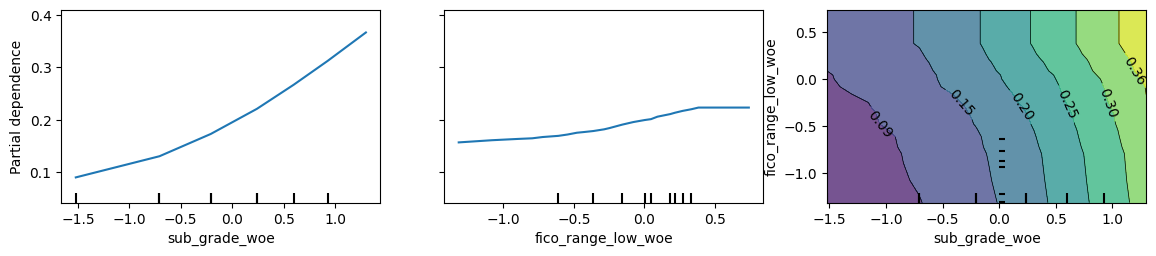

In [62]:
shap_explainer.partial_dependence_plot(['sub_grade_woe', 'fico_range_low_woe'])